In [1]:
import numpy as np, curvedsky as cs, plottools as pl, cmb as CMB, cosmology, healpy as hp, local
from matplotlib.pyplot import *
import warnings
warnings.filterwarnings("ignore")
ac2rad  = np.pi/10800.
deg2rad = np.pi/180.

In [2]:
def noise(lcl,sigp,theta,nu,name,dalpha=1.):
    lmax = len(lcl[0,:]) - 1
    L = np.linspace(0,lmax,lmax+1)
    nl = np.zeros((4,lmax+1))
    nl[0,:] = .5*(sigp*ac2rad/CMB.Tcmb)**2*np.exp(L*(L+1)*(theta*ac2rad)**2/8./np.log(2.))
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    if nu!=0.:
        fEE, fBB = local.foreground(nu,L,name)
        nl[1,:] += fEE
        nl[2,:] += fBB
    Lcl = lcl.copy()
    Lcl[2,:] *= dalpha
    return Lcl + nl

In [3]:
def rec(Lmax,rlmin,rlmax,lcl,ocl):
    Ag = {}
    #Ag['TE'], __ = cs.norm_ilens.qte(Lmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[1,:])
    #Ag['EE'], __ = cs.norm_ilens.qee(Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:])
    Ag['TB'] = cs.norm_imag.qtb('lens',Lmax,rlmin,rlmax,lcl[3,:],ocl[0,:],ocl[2,:])[0]
    Ag['EB'] = cs.norm_imag.qeb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])[0]
    Ag['BB'] = cs.norm_imag.qbb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[2,:])[0]
    return Ag

In [15]:
def snr_ilens(Ag,ucl,L,q,Lmin=8,corr=1.,fsky=.6):
    if q=='MV':
        Nl = 1./(1./Ag['EB']+1./Ag['TB']+1./Ag['BB'])
    elif q=='noBB':
        Nl = 1./(1./Ag['EB']+1./Ag['TB'])
    else:
        Nl = Ag[q]
    SN = (2*L+1.)*ucl[3]/Nl * corr**2 * fsky
    sn = deg2rad * np.sqrt( np.sum(SN[Lmin:]) )
    return 1./sn

In [5]:
def rhoI_plk(l):
    if l<500:
        return l*(.6-.4)/(500.) + .4
    else:
        return (l-500.)*(.4-.6)/(2050-500.) + .6

In [6]:
Lmax  = 3000       # maximum multipole of output normalization
rlmin, rlmax = 50, Lmax  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = L*(L+1)/2/np.pi
M = np.array([[1.,0],[1.,1.]])

In [7]:
ucl = CMB.read_camb_cls('../data/local/cosmo2017_10K_acc3_scalCls.dat',output='array')[:,:Lmax+1]
lcl = CMB.read_camb_cls('../data/local/cosmo2017_10K_acc3_lensedCls.dat',ftype='lens',output='array')[:,:Lmax+1]

In [8]:
name = 'PlanckHFI'
freqs, sigps, thetas = local.experiments(name)

In [9]:
Lk, nkk, cnkk = np.loadtxt('/global/cscratch1/sd/toshiyan/PR3/lens/COM_Lensing_4096_R3.00/MV/nlkk.dat',unpack=True,usecols=(0,1,2))
rhok = ((cnkk-nkk)/cnkk)[:Lmax+1]

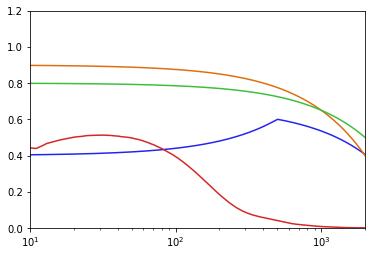

In [10]:
xlim(10,2000)
ylim(0,1.2)
xscale('log')
rhoI = (0.4-0.9)/(2000.)*L+0.9
rhoc = (0.5-0.8)/(2000.)*L+0.8
rhoP = np.array( [ rhoI_plk(l) for l in L ] )
plot(L,rhoP)
plot(L,rhoI)
plot(L,rhoc)
plot(Lk[:Lmax+1],rhok)

In [16]:
sig = {}
for nu, sigp, theta in zip(freqs,sigps,thetas):
    print(nu,sigp,theta)
    ocl = noise(lcl,sigp,theta,nu,name)
    Ag  = rec(Lmax,rlmin,rlmax,lcl,ocl)
    for q in ['TB','EB','BB','noBB','MV']:
        print(q)
        snrP = snr_ilens(Ag,ucl,L,q,corr=rhoP)
        #snrI = snr_ilens(Ag,ucl,L,corr=rhoI)
        snrc = snr_ilens(Ag,ucl,L,q,corr=rhoc)
        snrk = snr_ilens(Ag,ucl,L,q,corr=rhok)
        print('cib:',"{:.2f}".format(snrP),'k:',"{:.2f}".format(snrk),'k+cib:',"{:.2f}".format(snrc))

100.0 73.53910524340095 9.7
TB
cib: 1.36 k: 2.02 k+cib: 0.85
EB
cib: 1.79 k: 2.47 k+cib: 1.09
BB
cib: 2.20 k: 4.23 k+cib: 1.44
noBB
cib: 1.08 k: 1.56 k+cib: 0.67
MV
cib: 0.97 k: 1.46 k+cib: 0.61
143.0 62.22539674441619 7.3
TB
cib: 0.95 k: 1.41 k+cib: 0.59
EB
cib: 1.19 k: 1.63 k+cib: 0.72
BB
cib: 1.45 k: 2.93 k+cib: 0.96
noBB
cib: 0.74 k: 1.07 k+cib: 0.46
MV
cib: 0.66 k: 1.00 k+cib: 0.41
217.0 90.50966799187809 5.0
TB
cib: 1.29 k: 1.87 k+cib: 0.80
EB
cib: 2.25 k: 3.13 k+cib: 1.37
BB
cib: 3.30 k: 7.48 k+cib: 2.26
noBB
cib: 1.12 k: 1.61 k+cib: 0.69
MV
cib: 1.06 k: 1.57 k+cib: 0.66
353.0 390.32294321497426 4.9
TB
cib: 7.96 k: 10.75 k+cib: 4.78
EB
cib: 38.98 k: 54.04 k+cib: 23.76
BB
cib: 62.15 k: 142.10 k+cib: 42.62
noBB
cib: 7.80 k: 10.55 k+cib: 4.69
MV
cib: 7.74 k: 10.52 k+cib: 4.66


In [21]:
ocl = noise(lcl,40.*np.sqrt(2.),6.,0.,'')
Ag  = rec(Lmax,rlmin,rlmax,lcl,ocl)
for q in ['TB','EB','BB','noBB','MV']:
    print(q)
    snrP = snr_ilens(Ag,ucl,L,q,corr=rhoP)
    snrc = snr_ilens(Ag,ucl,L,q,corr=rhoc)
    snrk = snr_ilens(Ag,ucl,L,q,corr=rhok)
    print('cib:',"{:.2f}".format(snrP),'k:',"{:.2f}".format(snrk),'k+cib:',"{:.2f}".format(snrc))

TB
cib: 0.72 k: 1.12 k+cib: 0.46
EB
cib: 0.82 k: 1.16 k+cib: 0.50
BB
cib: 0.95 k: 1.98 k+cib: 0.63
noBB
cib: 0.54 k: 0.80 k+cib: 0.34
MV
cib: 0.47 k: 0.74 k+cib: 0.30
